# Jovian Analysis - Consolidated Notebook

**Unified notebook for Jovian calldata footprint gas scalar analysis**

## Features
- ✅ **Multi-chain support**: Base, OP Mainnet etc.
- ✅ **Flexible sampling**: Top percentile or random sampling
- ✅ **Date range analysis**: Analyze multiple dates with per-date breakdown
- ✅ **Dynamic gas limits**: Uses per-chain historical CSV data
- ✅ **Compression analysis**: FastLZ compression ratios and DA efficiency
- ✅ **Enhanced visualizations**: Comprehensive charts with recommendations
- ✅ **Caching system**: Local parquet files for performance
- ✅ **Optimal recommendations**: Data-driven scalar suggestions

## Quick Start
1. **Configure parameters** in the cell below
2. **Run all cells** to perform analysis
3. **Review results** in the generated visualizations

In [1]:
%load_ext autoreload
%autoreload 2

## Step 1: Setup and Imports

In [2]:
# Core imports
import sys
from pathlib import Path
import polars as pl
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import time
import numpy as np

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Import Jovian modules
from jovian_src.chain_config import (
    get_chain_display_name,
    get_chain_color,
    DEFAULT_CALLDATA_FOOTPRINT_GAS_SCALARS
)
from jovian_src.clickhouse_fetcher import (
    load_gas_limits,
    fetch_top_percentile_blocks,
    fetch_random_sample_blocks
)
from jovian_src.analysis_functions import (
    perform_jovian_analysis,
    generate_jovian_recommendation
)
from jovian_src.visualization_jovian import (
    generate_all_visualizations,
    plot_block_metric_distribution
)

from jovian_src.helper import get_gas_limit_for_date

print("✅ Modules loaded successfully")
print(f"✅ Available scalars: {DEFAULT_CALLDATA_FOOTPRINT_GAS_SCALARS}")

✅ Modules loaded successfully
✅ Available scalars: [160, 400, 600, 800]


## Step 2: Configuration

**Edit these parameters to customize your analysis:**

In [3]:
# ============================================================================
# ANALYSIS CONFIGURATION - EDIT THESE PARAMETERS
# ============================================================================

# Chain selection
CHAIN = "op"  # Options: base, op

# Sampling method
SAMPLING_METHOD = "random"  # "top_percentile" or "random"
PERCENTILE = 99.0    # For top percentile (99 = top 1%)
NUM_BLOCKS = 100     # For random sampling - blocks per day
RANDOM_SEED = 42     # For reproducible random sampling
SAMPLE_FRACTION = 0.01  # For random sampling (1% = 0.01)

# Date range
START_DATE = "2025-03-01"
END_DATE = "2025-06-30"  # Inclusive

# Analysis parameters
CALLDATA_FOOTPRINT_GAS_SCALARS = DEFAULT_CALLDATA_FOOTPRINT_GAS_SCALARS  # [160, 400, 600, 800]
BLOCK_LIMIT = None   # None = all blocks for selected method
FORCE_REFRESH = False  # Set True to ignore cache and re-download

# Output settings
SAVE_RESULTS = True
SHOW_PLOTS = True

print("✅ Configuration loaded:")
print(f"   Chain: {CHAIN}")
print(f"   Method: {SAMPLING_METHOD}")
if SAMPLING_METHOD == "top_percentile":
    print(f"   Percentile: Top {100-PERCENTILE}%")
else:
    print(f"   Sample: {int(SAMPLE_FRACTION*100)}% random")
print(f"   Date range: {START_DATE} to {END_DATE}")

✅ Configuration loaded:
   Chain: op
   Method: random
   Sample: 1% random
   Date range: 2025-03-01 to 2025-06-30


## Step 3: Initialize Analysis Environment

In [4]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================

# Paths
DATA_PATH = Path("../gas_limits")
FILE_PATH = f"{CHAIN}_gas_limits.csv"
CACHE_DIR = Path(".cache")
OUTPUT_DIR = Path(f"../results/{CHAIN}/jovian_analysis_{SAMPLING_METHOD}_{START_DATE}_{END_DATE}")

# Create output directory
if SAVE_RESULTS:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"📁 Output directory: {OUTPUT_DIR}")

# Generate date list
start = datetime.strptime(START_DATE, "%Y-%m-%d")
end = datetime.strptime(END_DATE, "%Y-%m-%d")
DATES_TO_ANALYZE = [(start + timedelta(days=i)).strftime("%Y-%m-%d") 
                     for i in range((end - start).days + 1)]

# Load gas limits
date_gas_limits = {}
print(f"📊 Loading gas limits for {CHAIN}...")
gas_limits_df = load_gas_limits(csv_path=f"{DATA_PATH}/{FILE_PATH}")
print(f"✅ Loaded gas limits for {len(date_gas_limits)} dates")

# Get gas limits for all dates

for date in DATES_TO_ANALYZE:
    gas_limit = get_gas_limit_for_date(date, gas_limits_df, chain=CHAIN)
    date_gas_limits[date] = gas_limit
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"📊 Gas limit for {date}: {gas_limit:,}")

# Determine gas limit for combined analysis
unique_limits = set(date_gas_limits.values())
if len(unique_limits) > 1:
    print(f"\n⚠️  Multiple gas limits detected: {', '.join(f'{gl:,}' for gl in sorted(unique_limits))}")
    # Use the most common gas limit for combined analysis
    limit_counts = Counter(date_gas_limits.values())
    ANALYSIS_GAS_LIMIT = limit_counts.most_common(1)[0][0]
    print(f"📊 Using most common for combined analysis: {ANALYSIS_GAS_LIMIT:,}")
else:
    ANALYSIS_GAS_LIMIT = list(unique_limits)[0]
    print(f"\n📊 Consistent gas limit across all dates: {ANALYSIS_GAS_LIMIT:,}")


# Cache configuration
def _method_key():
    """Generate cache key based on sampling method and parameters."""
    if SAMPLING_METHOD == "top_percentile":
        return f"top{PERCENTILE*100:.1f}pct_lim{BLOCK_LIMIT}"
    return f"rand_frac{SAMPLE_FRACTION}_seed{RANDOM_SEED}"

def _cache_path(date_str: str) -> Path:
    """Generate cache file path for a specific date."""
    return CACHE_DIR / CHAIN / _method_key() / f"{date_str}.parquet"

print(f"🔧 Cache method: {_method_key()}")
print(f"📅 Dates to analyze: {len(DATES_TO_ANALYZE)}")

📁 Output directory: ../results/op/jovian_analysis_random_2025-03-01_2025-06-30
📊 Loading gas limits for op...
✅ Loaded gas limits for 0 dates

⚠️  Multiple gas limits detected: 40,000,000, 53,547,685, 60,000,000
📊 Using most common for combined analysis: 60,000,000
🔧 Cache method: rand_frac0.01_seed42
📅 Dates to analyze: 122


## Step 4: Data Fetching and Caching

In [5]:
# ============================================================================
# DATA FETCHING WITH CACHING
# ============================================================================

print(f"📥 Fetching data for {CHAIN} using {SAMPLING_METHOD} method...")
print("=" * 60)

all_dataframes = []
fetch_summary = []
per_date_dataframes = {}

# Display method description
method_display = f"top {100-PERCENTILE}%" if SAMPLING_METHOD == "top_percentile" else f"{int(SAMPLE_FRACTION*100)}% random"
print(f"📊 Method: {method_display} blocks")

start_time = time.time()

for date in DATES_TO_ANALYZE:

    # Get gas limit for this date from the dictionary
    gas_limit = date_gas_limits[date]
    cache_file = _cache_path(date)


    # Show progress for shorter date ranges
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"\n📅 {date} (gas limit: {gas_limit:,})")
    
    # Check cache first
    if cache_file.exists() and not FORCE_REFRESH:
        df = pl.read_parquet(cache_file)
        actual_gas_limit = gas_limit
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   📦 Cache hit → {len(df):,} transactions")
    else:
        # Fetch from source
        cache_file.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            if SAMPLING_METHOD == "top_percentile":
                df, actual_gas_limit = fetch_top_percentile_blocks(
                    chain=CHAIN,
                    date=date,
                    percentile=PERCENTILE,
                    limit=BLOCK_LIMIT,
                    gas_limit=gas_limit
                )
            else:
                df, actual_gas_limit = fetch_random_sample_blocks(
                    chain=CHAIN,
                    date=date,
                    sample_fraction=SAMPLE_FRACTION,
                    gas_limit=gas_limit,
                    seed=RANDOM_SEED
                )
            
            # Save to cache if we got data
            if not df.is_empty():
                df.write_parquet(cache_file)
                if len(DATES_TO_ANALYZE) <= 7:
                    print(f"   💾 Saved to cache → {len(df):,} transactions")
            
        except Exception as e:
            print(f"   ❌ Error fetching {date}: {e}")
            df = pl.DataFrame()
            actual_gas_limit = gas_limit
    
    # Process results
    if not df.is_empty():
        all_dataframes.append(df)
        per_date_dataframes[date] = df
        blocks = df['block_number'].n_unique()
        txs = len(df)
        fetch_summary.append({
            'date': date,
            'blocks': blocks,
            'transactions': txs,
            'gas_limit': actual_gas_limit,
            'df': df
        })
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ✅ {blocks} blocks, {txs:,} transactions")
    else:
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ⚠️  No data for {date}")

total_time = time.time() - start_time
print(f"\n📊 Fetching complete!")
print(f"   Total time: {total_time:.1f}s")
print(f"   Average per date: {total_time/len(DATES_TO_ANALYZE):.1f}s")

# Combine all data
if all_dataframes:
    combined_df = pl.concat(all_dataframes)
    print(f"\n✅ Data summary:")
    print(f"   Total dates with data: {len(fetch_summary)}")
    print(f"   Total blocks: {combined_df['block_number'].n_unique():,}")
    print(f"   Total transactions: {len(combined_df):,}")
else:
    print("\n❌ No data retrieved. Please check your parameters.")
    combined_df = pl.DataFrame()

# Determine gas limit for combined analysis
unique_limits = set(date_gas_limits.values())
if len(unique_limits) > 1:
    print(f"\n⚠️  Multiple gas limits detected: {', '.join(f'{gl:,}' for gl in sorted(unique_limits))}")
    # Use the most common gas limit for combined analysis
    limit_counts = Counter(date_gas_limits.values())
    ANALYSIS_GAS_LIMIT = limit_counts.most_common(1)[0][0]
    print(f"📊 Using most common for combined analysis: {ANALYSIS_GAS_LIMIT:,}")
else:
    ANALYSIS_GAS_LIMIT = list(unique_limits)[0]
    print(f"\n📊 Consistent gas limit across all dates: {ANALYSIS_GAS_LIMIT:,}")

📥 Fetching data for op using random method...
📊 Method: 1% random blocks

📊 Fetching complete!
   Total time: 1.1s
   Average per date: 0.0s

✅ Data summary:
   Total dates with data: 122
   Total blocks: 52,704
   Total transactions: 1,252,141

⚠️  Multiple gas limits detected: 40,000,000, 53,547,685, 60,000,000
📊 Using most common for combined analysis: 60,000,000


## Step 5: Jovian Analysis

In [6]:
# Analyze combined data with multiple calldata footprint gas scalars
if not combined_df.is_empty():
    print(f"📊 ANALYZING COMBINED DATA")
    print("=" * 60)
    print(f"Chain: {get_chain_display_name(CHAIN)}")
    print(f"Dates analyzed: {len(fetch_summary)}")
    print(f"Gas limit: {ANALYSIS_GAS_LIMIT:,}")
    print(f"Sampling method: {SAMPLING_METHOD}")
    
    analysis_results = perform_jovian_analysis(
        df=combined_df,
        gas_limit=ANALYSIS_GAS_LIMIT,
        calldata_footprint_gas_scalars=CALLDATA_FOOTPRINT_GAS_SCALARS,
        chain=CHAIN,
        sampling_method=SAMPLING_METHOD,
        start_date=START_DATE,
        end_date=END_DATE,
        show_progress=True
    )
    
    print("\n✅ Jovian analysis complete!")
else:
    print("❌ No data to analyze")
    analysis_results = {}

📊 ANALYZING COMBINED DATA
Chain: OP Mainnet
Dates analyzed: 122
Gas limit: 60,000,000
Sampling method: random

🚀 JOVIAN ANALYSIS SUMMARY
Chain: OP Mainnet
Sampling Method: random
Date Range: 2025-03-01 → 2025-06-30
Gas Limit: 60,000,000
Calldata Footprint Gas Scalars: [160, 400, 600, 800]

📊 Analyzing OP Mainnet with calldata footprint gas scalar: 160
   Effective limit: 375,000 bytes
   Sampling method: random
🚀 Analyzing 52704 blocks with 10 workers...


Processing blocks: 100%|██████████| 52704/52704 [00:27<00:00, 1908.13it/s]


   ✅ Blocks exceeding: 0/52704 (0.0%)
   📈 Avg utilization: 0.63%
   🗜️ Avg compression ratio: 2.07x

📊 Analyzing OP Mainnet with calldata footprint gas scalar: 400
   Effective limit: 150,000 bytes
   Sampling method: random
🚀 Analyzing 52704 blocks with 10 workers...


Processing blocks: 100%|██████████| 52704/52704 [00:26<00:00, 1972.39it/s]


   ✅ Blocks exceeding: 0/52704 (0.0%)
   📈 Avg utilization: 1.58%
   🗜️ Avg compression ratio: 2.07x

📊 Analyzing OP Mainnet with calldata footprint gas scalar: 600
   Effective limit: 100,000 bytes
   Sampling method: random
🚀 Analyzing 52704 blocks with 10 workers...


Processing blocks: 100%|██████████| 52704/52704 [00:27<00:00, 1920.17it/s]


   ✅ Blocks exceeding: 0/52704 (0.0%)
   📈 Avg utilization: 2.38%
   🗜️ Avg compression ratio: 2.07x

📊 Analyzing OP Mainnet with calldata footprint gas scalar: 800
   Effective limit: 75,000 bytes
   Sampling method: random
🚀 Analyzing 52704 blocks with 10 workers...


Processing blocks: 100%|██████████| 52704/52704 [00:28<00:00, 1851.27it/s]


   ✅ Blocks exceeding: 3/52704 (0.0%)
   📈 Avg utilization: 3.17%
   🗜️ Avg compression ratio: 2.07x

✅ Jovian analysis complete!


## Step 6: View Results with Compression Metrics

In [7]:
# Display analysis results including compression metrics
if analysis_results:
    print(f"🚀 JOVIAN ANALYSIS RESULTS - {get_chain_display_name(CHAIN)}")
    print("=" * 60)
    
    for scalar in sorted(analysis_results.keys()):
        result = analysis_results[scalar]
        print(f"\n🔹 Calldata Footprint Gas Scalar: {scalar}")
        print(f"   Effective limit: {result.gas_limit // scalar:,} bytes")
        print(f"   Blocks exceeding: {result.blocks_exceeding}/{result.total_blocks} ({result.percentage_exceeding:.2f}%)")
        print(f"   Avg utilization: {result.avg_utilization:.2%}")
        print(f"   Max utilization: {result.max_utilization:.2%}")

        # ⛽ DA footprint vs *block gas used* (as % of gas used)
        if getattr(result, "blocks_with_gas_used", 0) > 0:
            mean_pct   = result.avg_util_vs_gas_used * 100
            median_pct = result.median_util_vs_gas_used * 100
            p95_pct    = result.p95_util_vs_gas_used * 100

            over_cnt_measured = int(round(result.share_over_1_vs_used * result.blocks_with_gas_used))
            over_pct_measured = result.share_over_1_vs_used * 100

            # Optional: express as share of ALL blocks too (matches the “Blocks exceeding” style)
            over_pct_all = (over_cnt_measured / result.total_blocks * 100) if result.total_blocks else 0

            print(f"\n   ⛽ DA footprint vs Block Gas Used:")
            print(f"      mean:   {mean_pct:.1f}%")
            print(f"      median: {median_pct:.1f}%   |   p95: {p95_pct:.1f}%")
            print(f"      Blocks over gas-used budget (>100%): "
                f"{over_cnt_measured}/{result.blocks_with_gas_used} ({over_pct_measured:.1f}%) ")
        else:
            print("\n   ⛽ DA footprint vs Block Gas Used: n/a (no blocks had block_gas_used)")
        
        # Show compression metrics
        if result.compression_metrics:
            print(f"\n   📊 Compression Metrics:")
            print(f"      Avg compression ratio: {result.compression_metrics.get('avg_compression_ratio', 0):.2f}x")
            print(f"      Median compression: {result.compression_metrics.get('median_compression_ratio', 0):.2f}x")
            print(f"      DA efficiency: {result.compression_metrics.get('avg_da_efficiency', 0):.1%}")
        
        if result.blocks_exceeding > 0:
            print(f"   Avg excess: {result.avg_excess_percentage:.1f}%")
            print(f"   Max excess: {result.max_excess_percentage:.1f}%")




🚀 JOVIAN ANALYSIS RESULTS - OP Mainnet

🔹 Calldata Footprint Gas Scalar: 160
   Effective limit: 375,000 bytes
   Blocks exceeding: 0/52704 (0.00%)
   Avg utilization: 0.63%
   Max utilization: 26.59%

   ⛽ DA footprint vs Block Gas Used:
      mean:   3.3%
      median: 3.2%   |   p95: 6.0%
      Blocks over gas-used budget (>100%): 0/52704 (0.0%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.07x
      Median compression: 1.89x
      DA efficiency: 37.1%

🔹 Calldata Footprint Gas Scalar: 400
   Effective limit: 150,000 bytes
   Blocks exceeding: 0/52704 (0.00%)
   Avg utilization: 1.58%
   Max utilization: 66.47%

   ⛽ DA footprint vs Block Gas Used:
      mean:   8.4%
      median: 7.9%   |   p95: 15.0%
      Blocks over gas-used budget (>100%): 6/52704 (0.0%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.07x
      Median compression: 1.89x
      DA efficiency: 37.1%

🔹 Calldata Footprint Gas Scalar: 600
   Effective limit: 100,000 bytes
   Blocks exceeding:

## Step 7: Generate Recommendations

In [8]:
print(f"\n🎯 RECOMMENDATION - {get_chain_display_name(CHAIN)}")
print("=" * 60)

rec = generate_jovian_recommendation(
    results=analysis_results,            
    chain=CHAIN,
    start_date=START_DATE,
    end_date=END_DATE,
    target_excess_rate=0.01
)

for opt in rec["all_options"]:
    s = opt["calldata_footprint_gas_scalar"]
    tick = "✅" if opt["blocks_exceeding_pct"] <= 1 else ("⚠️" if opt["blocks_exceeding_pct"] <= 5 else "❌")

    # Avg compression from recommendation dict
    avg_comp = opt.get("avg_compression_ratio", 0.0)

    # Median compression from analysis_results (no lib changes needed)
    median_comp = 0.0
    if s in analysis_results and analysis_results[s].compression_metrics:
        median_comp = analysis_results[s].compression_metrics.get("median_compression_ratio", 0.0)

    # DA footprint > gas used share (only if measured)
    measured = opt.get("measured_blocks_gas_used", 0) or 0
    over_pct = opt.get("over_gas_used_pct", None)
    over_str = (
        f" | DA footprint > block gas used: {over_pct:.2f}% of {measured:,} blocks"
        if (over_pct is not None and measured > 0) else ""
    )

    print(
        f"{tick} Scalar {s}: {opt['blocks_exceeding_pct']:.2f}% exceeds gas limit, {opt['assessment']} | "
        f"avg comp {avg_comp:.2f}x (median {median_comp:.2f}x){over_str}"
    )



🎯 RECOMMENDATION - OP Mainnet
✅ Scalar 160: 0.00% exceeds gas limit, Very Conservative | avg comp 2.07x (median 1.89x) | DA footprint > block gas used: 0.00% of 52,704 blocks
✅ Scalar 400: 0.00% exceeds gas limit, Very Conservative | avg comp 2.07x (median 1.89x) | DA footprint > block gas used: 0.01% of 52,704 blocks
✅ Scalar 600: 0.00% exceeds gas limit, Very Conservative | avg comp 2.07x (median 1.89x) | DA footprint > block gas used: 0.06% of 52,704 blocks
✅ Scalar 800: 0.01% exceeds gas limit, Conservative | avg comp 2.07x (median 1.89x) | DA footprint > block gas used: 0.09% of 52,704 blocks


## Step 8: Generate Visualizations

📊 Generating enhanced visualizations for OP Mainnet...
📊 Generating enhanced size estimates histogram...
✅ Saved size estimates histogram to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/1_size_estimates_histogram.png
📊 Generating compression ratio histogram...
✅ Saved enhanced compression histogram to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/2_compression_histogram.png
📊 Generating exceeding limits analysis...
✅ Saved exceeding limits analysis to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/3_exceeding_limits_analysis.png
📊 Generating excess distribution...
✅ Saved excess distribution to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/4_excess_distribution.png
📊 Generating over-utilization analysis...
✅ Saved over-utilization analysis to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/5_over_utilization_analysis.png
📊 Generating scalar comparison...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:744: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved scalar comparison to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/6_scalar_comparison.png
📊 Generating comprehensive summary...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:1095: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_analysis/jovian_src/visualization_jovian.py:1099: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved comprehensive summary to ../results/op/jovian_analysis_random_2025-03-01_2025-06-30/7_comprehensive_summary.png
✅ Generated 7 visualizations

✅ Generated 7 visualizations:
   1. Size estimates histogram (with vertical lines & zones)
   2. Compression ratio histogram (with percentiles & zones)
   3. Blocks exceeding limits analysis
   4. Excess distribution
   5. Over-utilization percentages
   6. Scalar comparison
   7. Comprehensive summary (NEW)

📁 Saved to: ../results/op/jovian_analysis_random_2025-03-01_2025-06-30


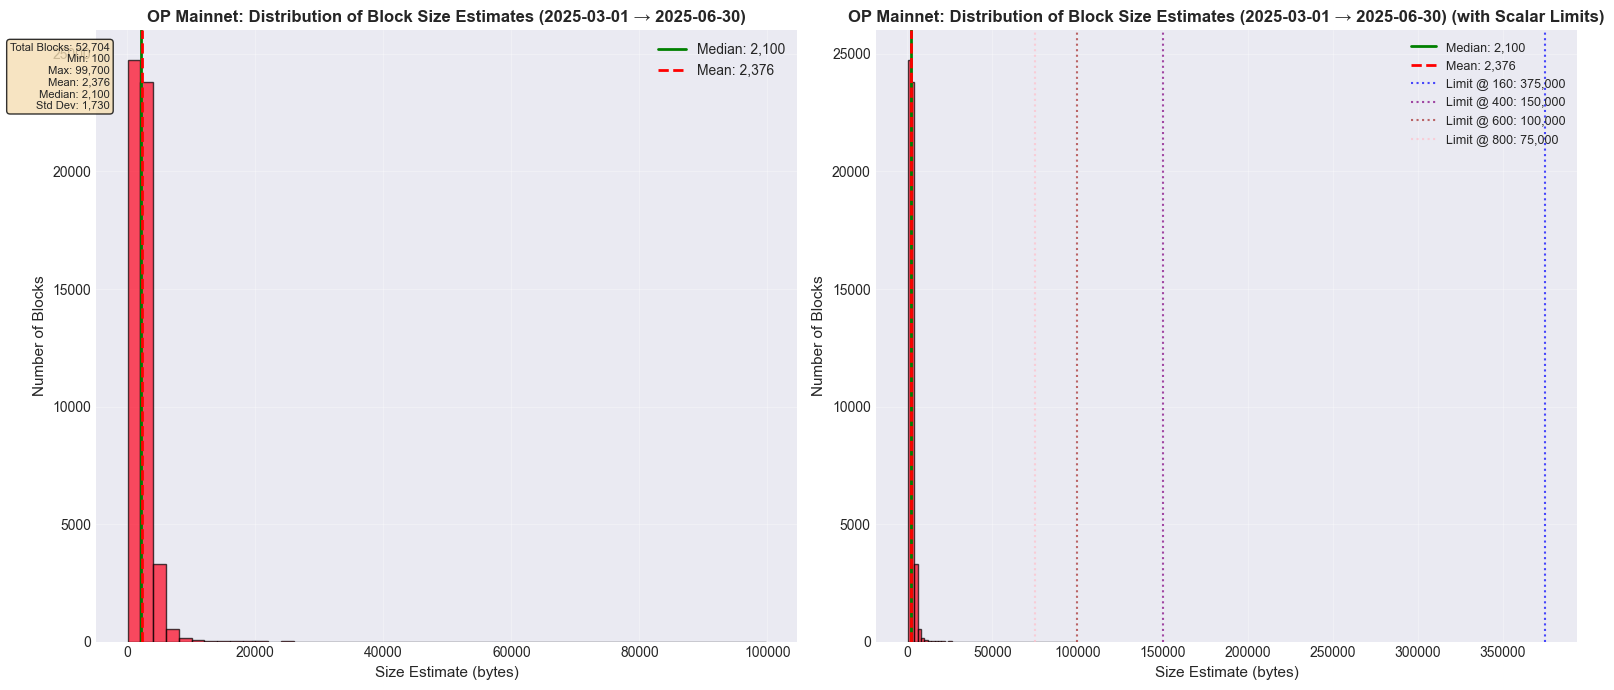

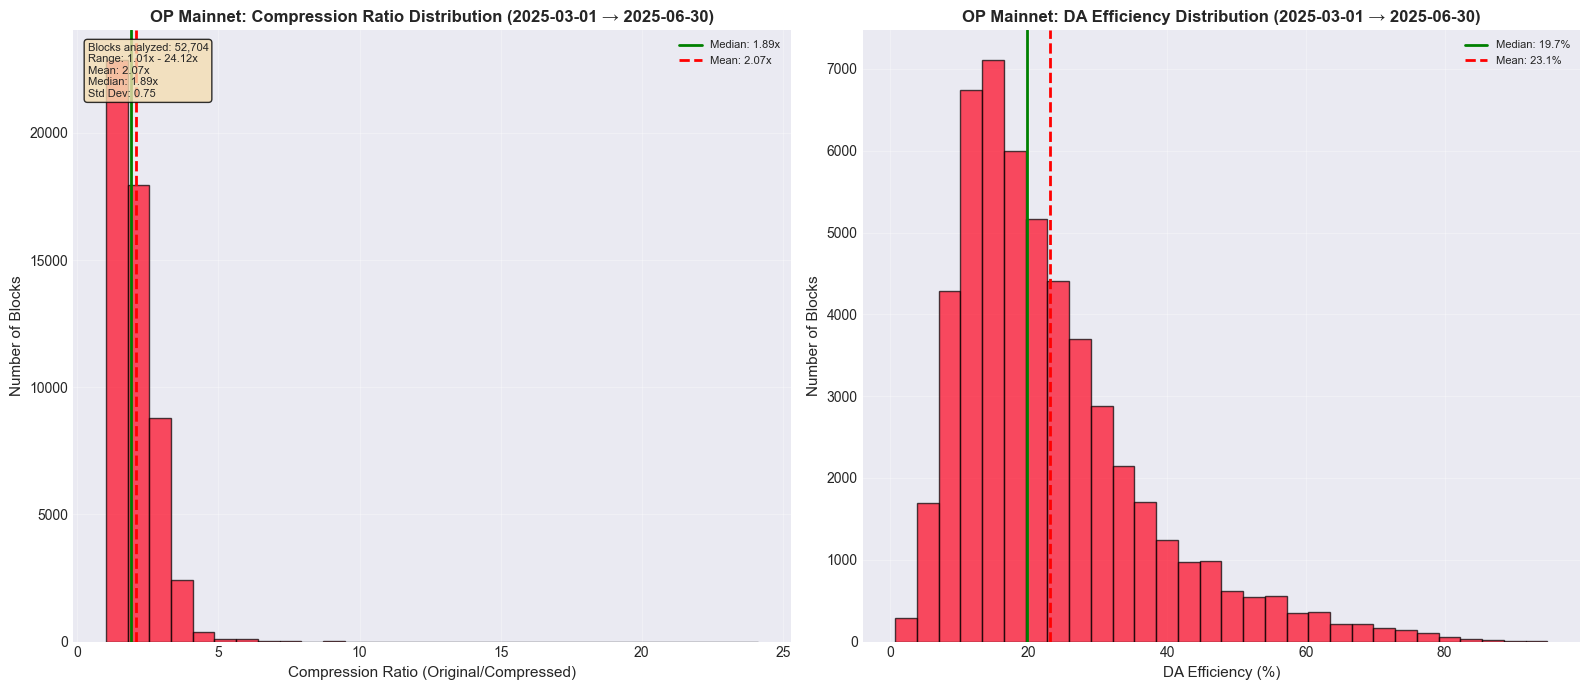

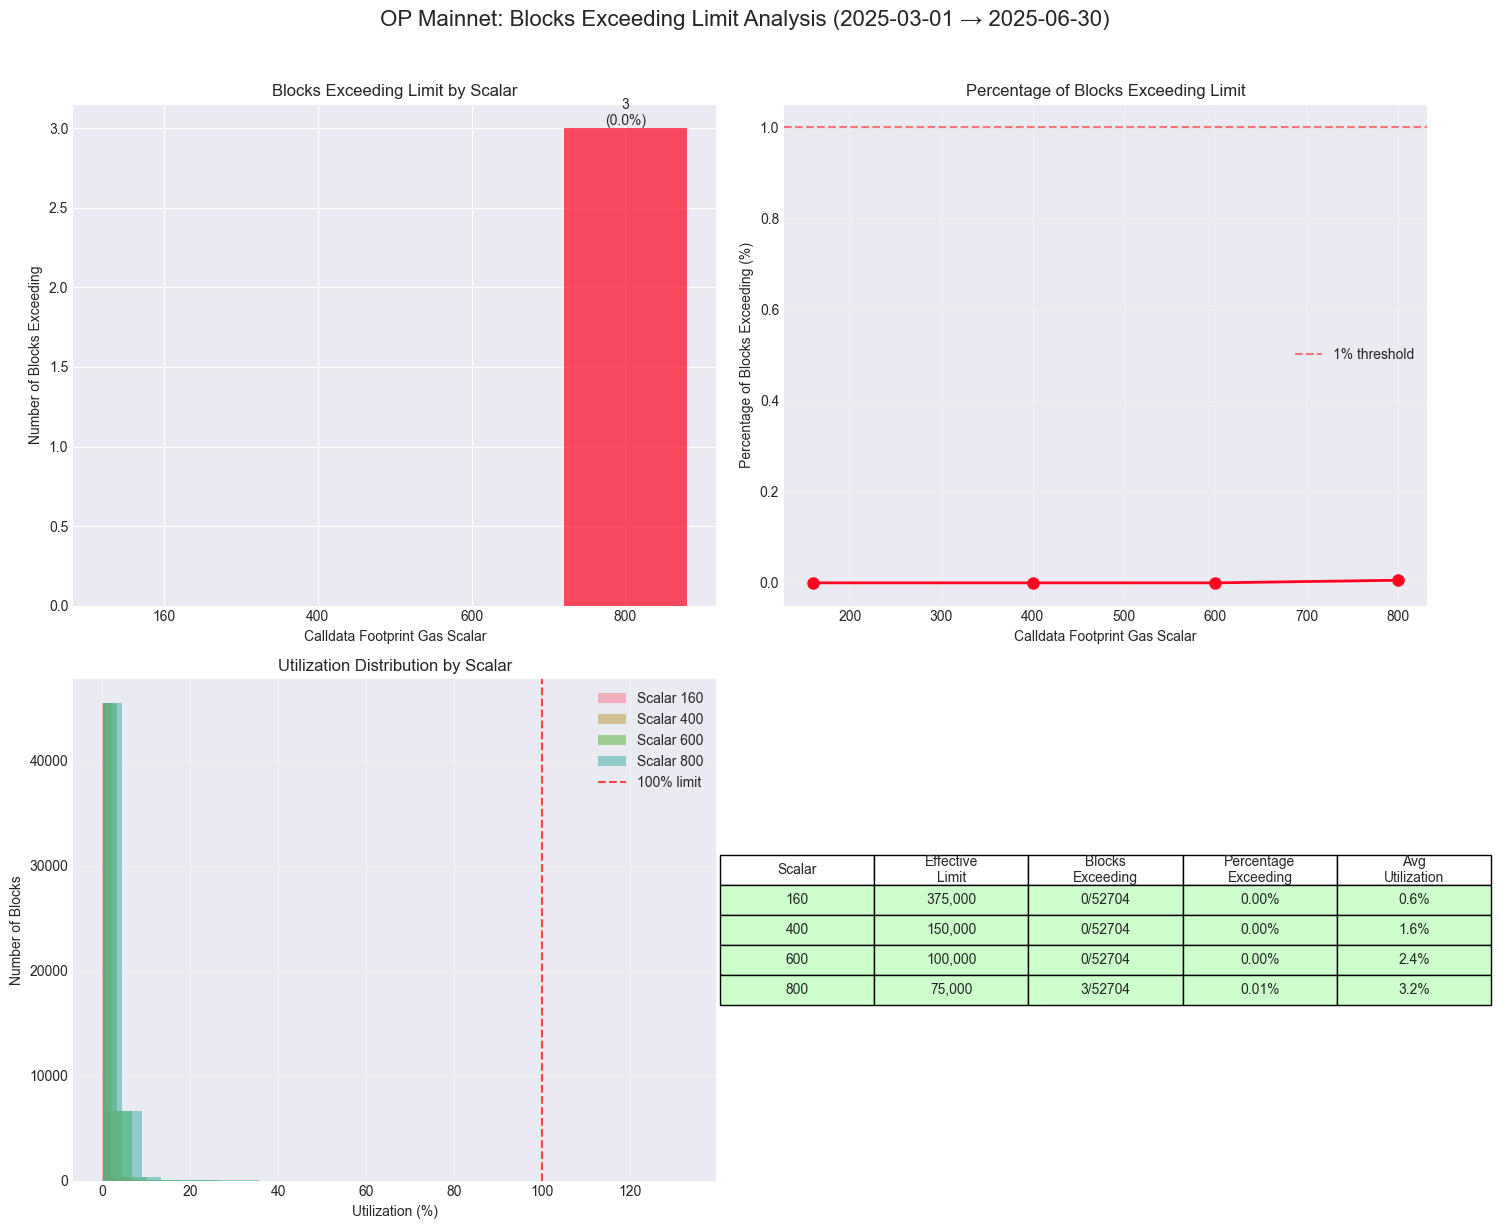

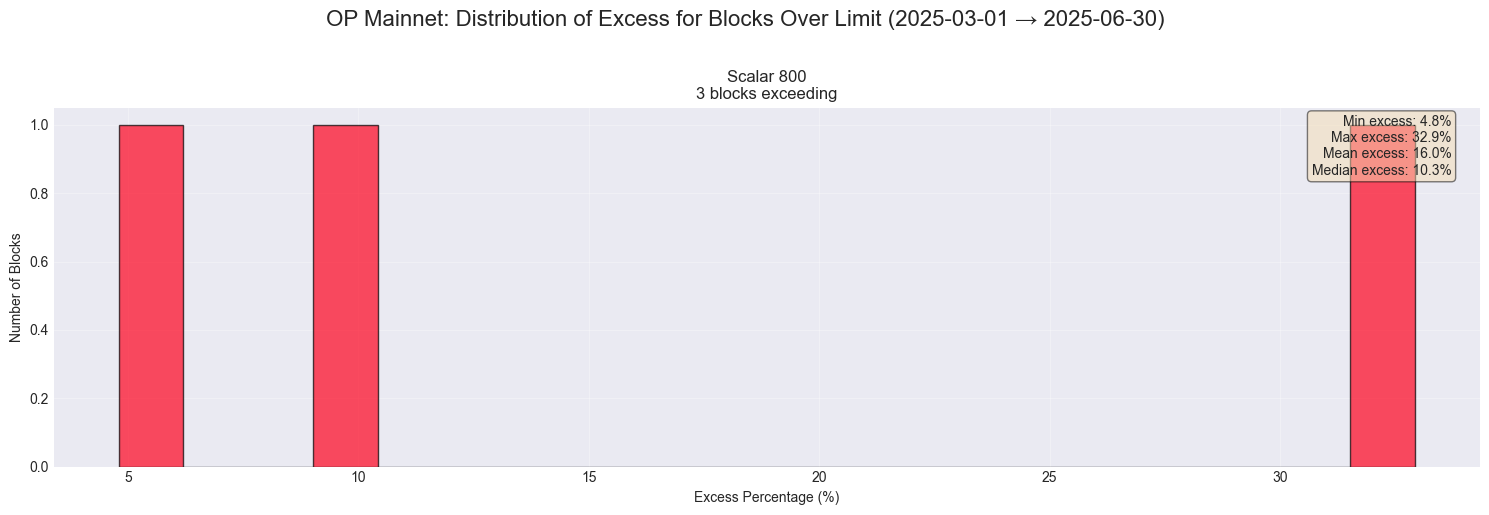

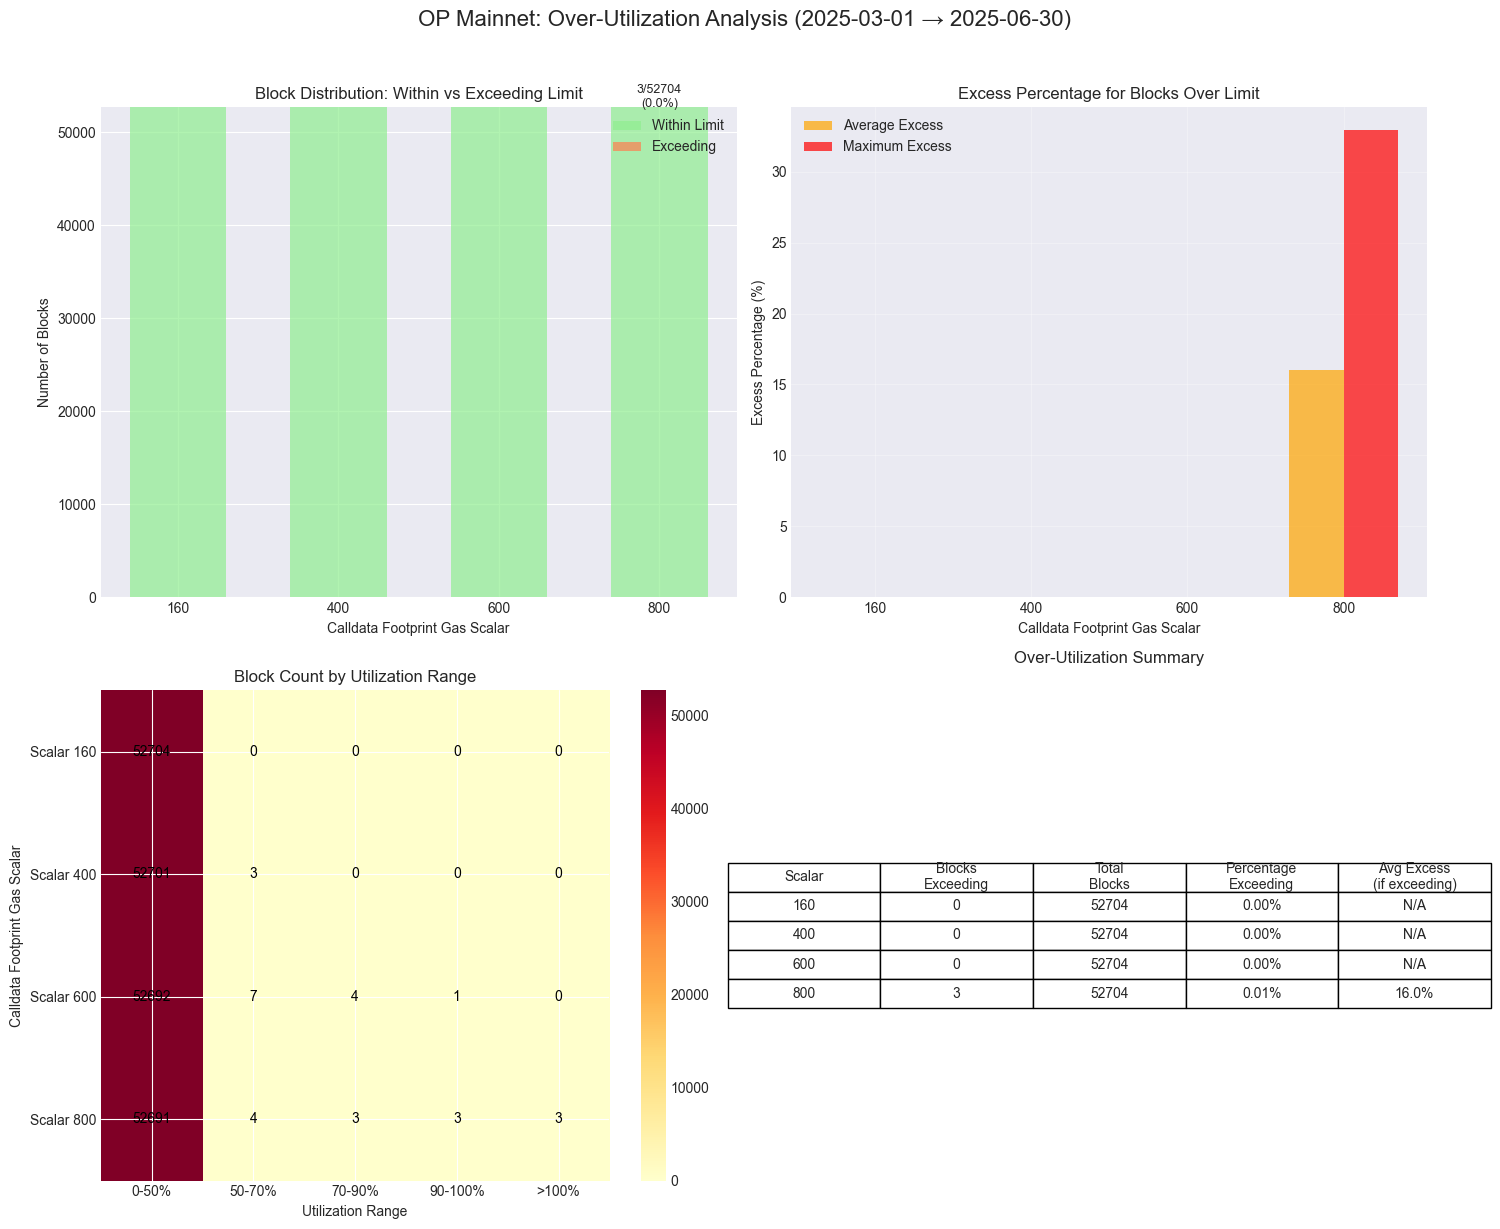

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


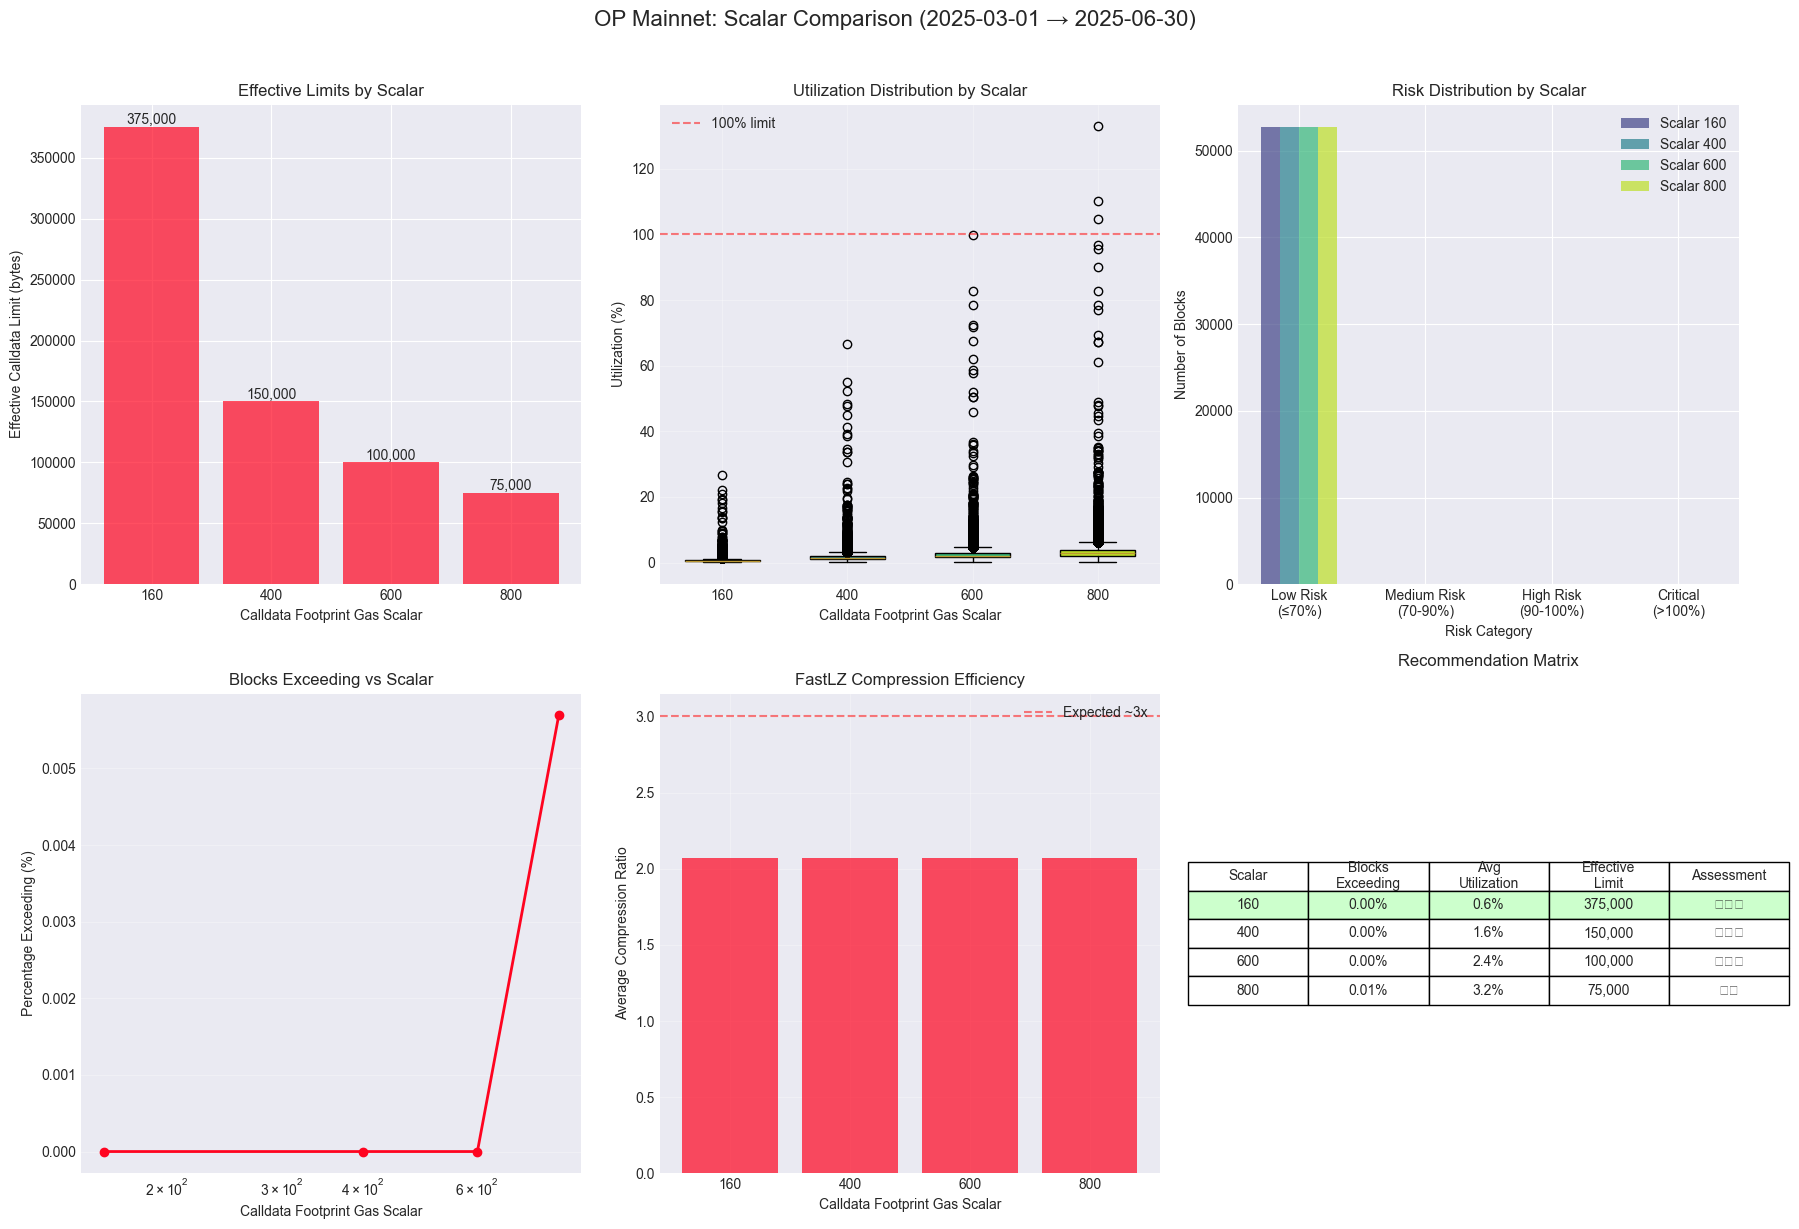

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


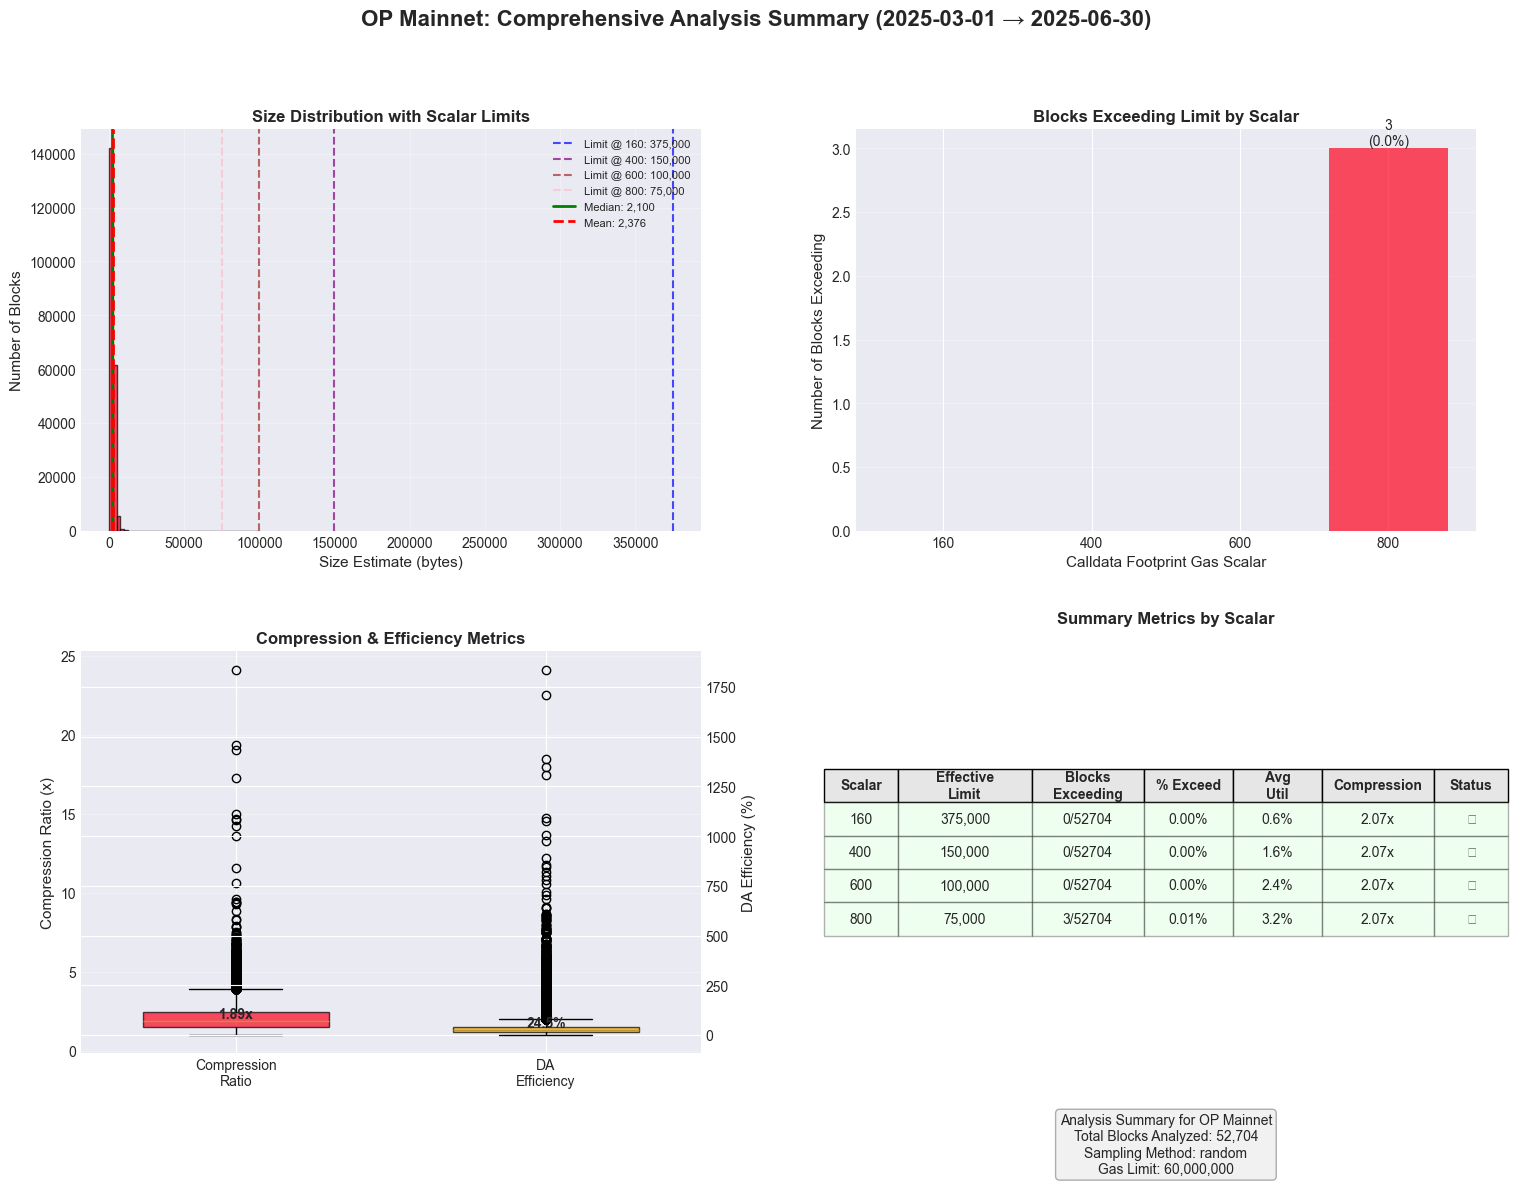

In [9]:
# Generate all Jovian visualizations with enhanced features
if analysis_results:
    print(f"📊 Generating enhanced visualizations for {get_chain_display_name(CHAIN)}...")
    
    # Generate all visualizations (includes new comprehensive summary)
    figures = generate_all_visualizations(
        results_by_scalar=analysis_results,
        output_dir=OUTPUT_DIR,
        chain=CHAIN,
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    print(f"\n✅ Generated {len(figures)} visualizations:")
    print("   1. Size estimates histogram (with vertical lines & zones)")
    print("   2. Compression ratio histogram (with percentiles & zones)")
    print("   3. Blocks exceeding limits analysis")
    print("   4. Excess distribution")
    print("   5. Over-utilization percentages")
    print("   6. Scalar comparison")
    print("   7. Comprehensive summary (NEW)")
    print(f"\n📁 Saved to: {OUTPUT_DIR}")

# Step 9: Verify Jovian Calculations

📊 DA size estimate / raw calldata per block
   n blocks: 52,704
   mean:   23.09%
   median: 19.70%


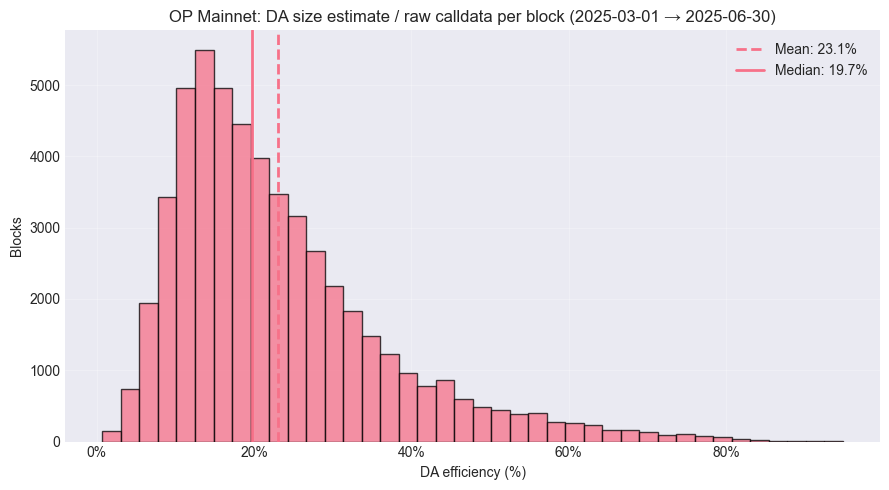

In [10]:
plot_block_metric_distribution(
    scalar_to_peek=400,
    analysis_results=analysis_results,
    metric_fn=lambda b: b.total_size_estimate / (b.total_calldata_size + 100 * b.tx_count),
    title="DA size estimate / raw calldata per block",
    xlabel="DA efficiency (%)",
    percent_scale=True,
    chain_name=get_chain_display_name(CHAIN),
    start_date=START_DATE,
    end_date=END_DATE,
    min_calldata=True
)


📊 Distribution of size_estimate / gas_used
   n blocks: 52,704
   mean:   8.37%
   median: 7.94%


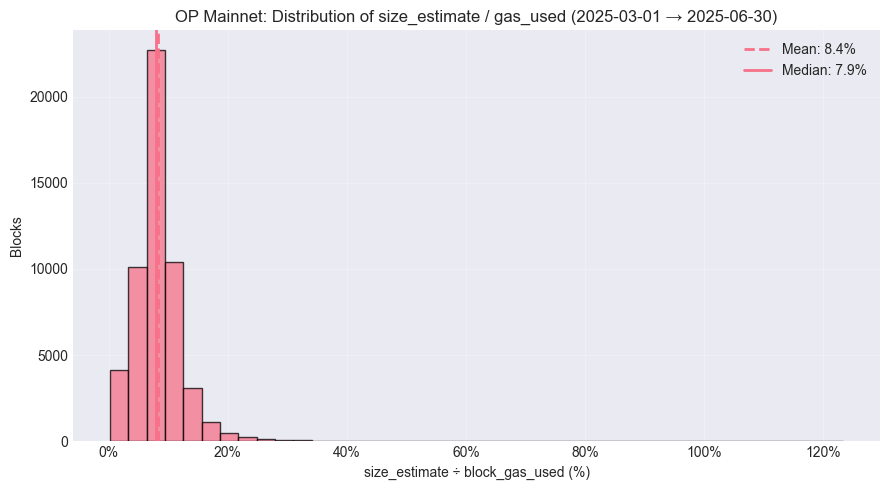

In [11]:
plot_block_metric_distribution(
    scalar_to_peek=400,
    analysis_results=analysis_results,
    metric_fn=lambda b: b.utilization_vs_gas_used,
    title="Distribution of size_estimate / gas_used",
    xlabel="size_estimate ÷ block_gas_used (%)",
    percent_scale=True,
    value_filter=lambda x: x is not None,
    chain_name=get_chain_display_name(CHAIN),
    start_date=START_DATE,
    end_date=END_DATE
)


## Usage Instructions

### To Analyze Different Chains:
1. Change `CHAIN = "base"` to `CHAIN = "op"` (or other chains)
2. Re-run the configuration cell and all subsequent cells

### To Change Sampling Method:
1. Change `SAMPLING_METHOD = "top_percentile"` to `SAMPLING_METHOD = "random"`
2. Adjust `PERCENTILE` or `SAMPLE_FRACTION` as needed
3. Re-run the configuration cell and all subsequent cells

### To Analyze Different Date Ranges:
1. Change `START_DATE` and `END_DATE`
2. Re-run the configuration cell and all subsequent cells

### To Force Refresh Data:
1. Set `FORCE_REFRESH = True`
2. Re-run the data fetching cell

### To Save Results:
1. Set `SAVE_RESULTS = True` (default)
2. Results will be saved to `../results/{chain}/`

### To Show Plots:
1. Set `SHOW_PLOTS = True` (default)
2. Plots will be displayed inline